# Introduction
This uses keyword analysis (as in Gries, 'A new approach to (key) keywords analysis') to look for key verticalities in the corpus.

### Imports
Import libraries and write settings here.

In [1]:
from music21 import *
import os
import csv
import itertools as it
from collections import Counter
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from IPython.display import Image
import math

In [2]:
## loads corpus

properCorpus = corpus.corpora.LocalCorpus('DPhilCorpus')
properCorpus.existsInSettings

properCorpus.addPath('~/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/')
properCorpus.directoryPaths

properCorpus.save()
properCorpus.existsInSettings

/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: DPhilCorpus metadata cache: starting processing of paths: 107
/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/cr/p20lv70n2wbf2w8jfmxbh69w0000gp/T/music21/local-DPhilCorpus.p.gz
bundles.py: WARNING: MetadataBundle Modification Time: 1608739421.2281358
bundles.py: WARNING: Skipped 107 sources already in cache.
/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: writing time: 0.141 md items: 107

/opt/anaconda3/lib/python3.7/site-packages/music21/corpus/corpora.py: WARNING: cache: filename: /var/folders/cr/p20lv70n2wbf2w8jfmxbh69w0000gp/T/music21/local-DPhilCorpus.p.gz


True

In [3]:
## organises corpus

pieceName = []

listOfWorks = properCorpus.search('Op.')
for el in listOfWorks:
    pieceName.append(el.sourcePath)

# Data Collection
Counts total durations of each verticality (normal order) but does not convert this into proportions for each movement.

In [4]:
## counts total durations

listOfAllVerticalities = []
listOfTotalResults = []
for el in pieceName:
    thePiece = corpus.parse(el)
    fileTitle = str(el).replace("/Users/joshua ballance/Desktop/Oxford/Corpus/Sounding Corpus (Movements)/XML/", "").replace(".xml", "").replace(".mxl", "")
    opusNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("i", "").replace("v", "")
    movementNumber = fileTitle.replace("Op.", "").replace(" ", "").replace("1", "").replace("2", "").replace("3", "").replace("4", "").replace("5", "").replace("6", "").replace("7", "").replace("8", "").replace("9", "").replace("0", "")
    chordifiedPiece = thePiece.chordify()
    chords = chordifiedPiece.flat.recurse().getElementsByClass('Chord')
    listOfNO = []
    listOfDurations = []
    listOfNOAndDuration = []
    for el in chords:
        temp = []
        transposedNormalOrder = []
        for i in el.primeForm:
            transposedNormalOrder.append(i)
        temp.append(transposedNormalOrder)
        temp.append(el.seconds)
        listOfNO.append(str(transposedNormalOrder))
        listOfDurations.append(el.seconds)
        listOfNOAndDuration.append(temp)
        listOfAllVerticalities.append(transposedNormalOrder)
    summarisedListOfNO = list(dict.fromkeys(listOfNO))
    summarisedListOfNOAndDuration = []
    for el in summarisedListOfNO:
        temp = []
        for i in listOfNOAndDuration:
            if el == str(i[0]):
                temp.append(i[1])
        newTemp = []
        newTemp.append(el)
        newTemp.append(sum(temp))
        summarisedListOfNOAndDuration.append(newTemp)
    temp = []
    temp.append(fileTitle)
    temp.append(opusNumber)
    temp.append(sum(listOfDurations))
    temp.append(summarisedListOfNOAndDuration)
    listOfTotalResults.append(temp)

In [5]:
## organises data and writes to CSV

newListOfAllVerticalities = []
for el in listOfAllVerticalities:
    if el in newListOfAllVerticalities:
        pass
    else:
        newListOfAllVerticalities.append(el)

newNewListOfAllVerticalities = sorted(newListOfAllVerticalities, key=len) 

newNewListOfAllVerticalities.sort(key=lambda x: x)
newNewListOfAllVerticalities = sorted(newNewListOfAllVerticalities, key=len)

finalListForCSV = []
firstLine = ['Title', 'Duration']
for el in newNewListOfAllVerticalities:
    firstLine.append(str(el).replace(",", ""))
finalListForCSV.append(firstLine)

listOfTotalResults.sort(key=lambda x: int(x[1]))
for el in listOfTotalResults:
    newLine = []
    newLine.append(el[0])
    newLine.append(el[2])
    tempListOfNO = []
    for j in el[3]:
        tempListOfNO.append(j[0])
    for i in newNewListOfAllVerticalities:
        if str(i) in tempListOfNO:
            for j in el[3]:
                if j[0] == str(i):
                    newLine.append(j[1])
        else:
            newLine.append(0)
    finalListForCSV.append(newLine)

csvOut=open("/Users/joshua ballance/Desktop/verticalities_pf_absolute_values.csv", "w") #open csv file, n.b. this is overwriting the file
titleWriter = csv.writer(csvOut, delimiter=',', quotechar='|')
csvOut.close()

for el in finalListForCSV:
    csvOut=open("/Users/joshua ballance/Desktop/verticalities_pf_absolute_values.csv", "a") #open csv file, n.b. this is appending the file
    barlineWriter = csv.writer(csvOut, delimiter=',', quotechar='|')
    barlineWriter.writerow(el)
    csvOut.close()

In [6]:
## loads data

data2 = pd.read_csv('/Users/joshua ballance/Desktop/verticalities_pf_absolute_values.csv', index_col=0)
proportions_data2 = pd.read_csv('/Users/joshua ballance/Desktop/verticalitiespf.csv', index_col=0)

# DKL Analysis

In [7]:
## calculates DKL values by using proportions data weighted by total number of trigrams in each movement to facilitate inter-movement comparison

DKL_values = []
corpus_duration = sum(data2.iloc[:, 0:1].values.flat)
for i in range(1,len(data2.columns)):
    list_of_plog_values = []
    summed_verticality_durations = sum(data2.iloc[:, i:i+1].values.flat)
    for j in range(0, len(data2.index)):
        movement_duration = float(data2.iloc[j:j+1, 0:1].values)
        verticality_duration = float(data2.iloc[j:j+1, i:i+1].values)
        verticality_proportion = verticality_duration/summed_verticality_durations
        movement_proportion = movement_duration/corpus_duration
        if verticality_proportion == 0:
            list_of_plog_values.append(0)
        else:
            plog2pq_value = verticality_proportion*(math.log2(verticality_proportion/movement_proportion))
            list_of_plog_values.append(plog2pq_value)
    verticality_plog_value = sum(list_of_plog_values)
    DKL_value = 1-(math.exp(-verticality_plog_value))
    DKL_values.append(DKL_value)     
    
totals = []
for k in range(0, len(proportions_data2.columns)):
    summed_proportion = sum(proportions_data2.iloc[:, k:k+1].values.flat)
    totals.append(summed_proportion)
total_proportions = []
for j in totals:
    new_total = j/sum(totals)
    total_proportions.append(new_total)
    
proportions_data2 = proportions_data2.transpose()
proportions_data2['Total'] = total_proportions
proportions_data2['DKL Value'] = DKL_values

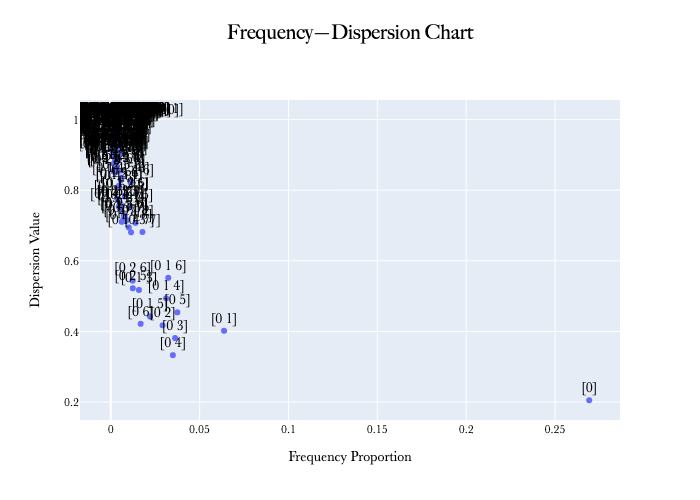

In [8]:
## plots DKL against frequency

fig = go.Figure()
fig.add_trace(go.Scatter(x = proportions_data2['Total'], y = proportions_data2['DKL Value'], mode='markers+text', text=proportions_data2.index.values, textposition="top center", textfont_size=14))
fig.update_layout(xaxis=(dict(title={'text': 'Frequency Proportion'})))
fig.update_layout(yaxis=(dict(title={'text': 'Dispersion Value'})))
fig.update_layout(title={'text': 'Frequency—Dispersion Chart', 'font':dict(family="Big Caslon, monospace", size=20, color='rgb(0,0,0)'), 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.update_layout(font=dict(family="Baskerville, monospace", size=12, color='rgb(0,0,0)'))
img_bytes = fig.to_image(format='png', scale=1)
fig.show()
Image(img_bytes)